Sample data saved to 'test_data_3d.json'
Creating interactive matplotlib plot...


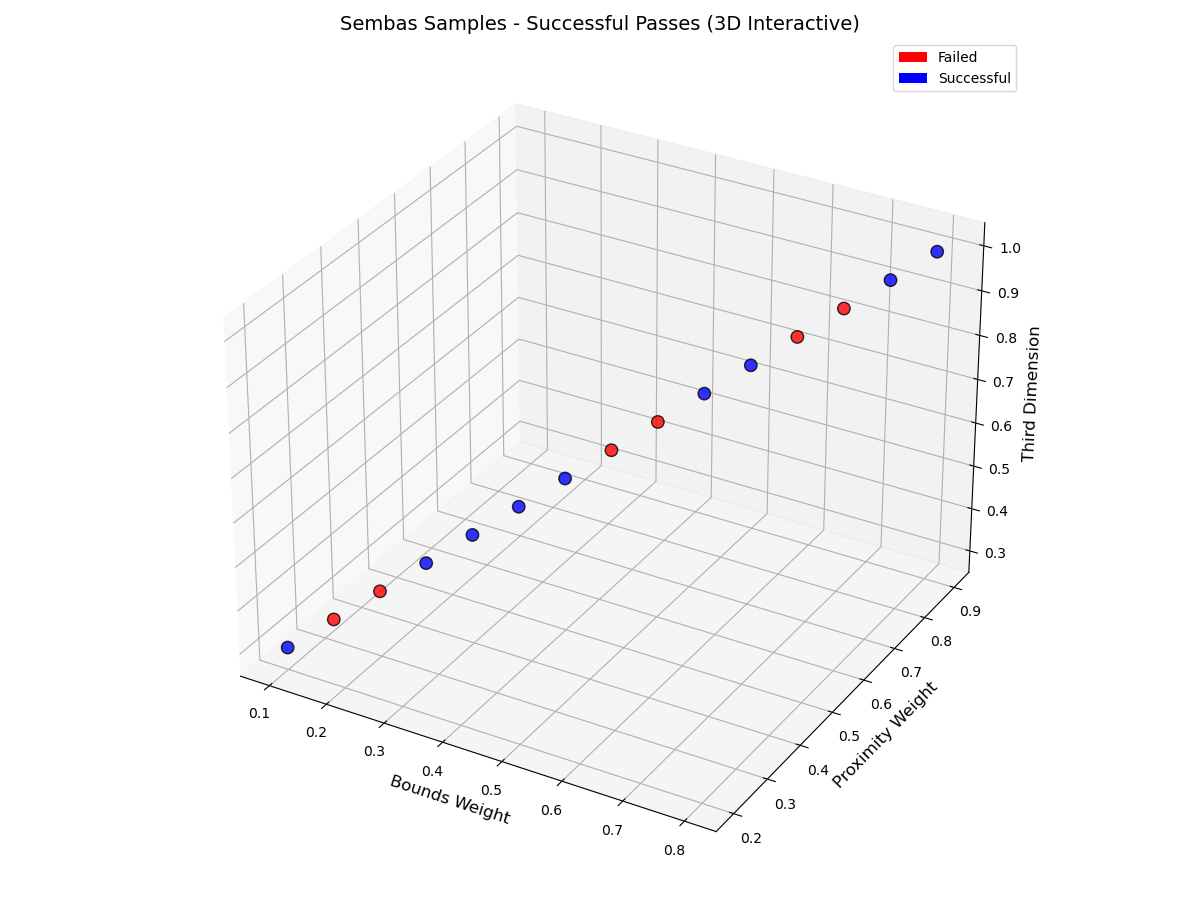


Creating interactive Plotly plot...


ValueError: 
    Invalid element(s) received for the 'color' property of scatter3d.marker
        Invalid elements include: ['Successful', 'Failed', 'Successful', 'Successful', 'Failed', 'Successful', 'Failed', 'Successful', 'Failed', 'Successful']

    The 'color' property is a color and may be specified as:
      - A hex string (e.g. '#ff0000')
      - An rgb/rgba string (e.g. 'rgb(255,0,0)')
      - An hsl/hsla string (e.g. 'hsl(0,100%,50%)')
      - An hsv/hsva string (e.g. 'hsv(0,100%,100%)')
      - A named CSS color:
            aliceblue, antiquewhite, aqua, aquamarine, azure,
            beige, bisque, black, blanchedalmond, blue,
            blueviolet, brown, burlywood, cadetblue,
            chartreuse, chocolate, coral, cornflowerblue,
            cornsilk, crimson, cyan, darkblue, darkcyan,
            darkgoldenrod, darkgray, darkgrey, darkgreen,
            darkkhaki, darkmagenta, darkolivegreen, darkorange,
            darkorchid, darkred, darksalmon, darkseagreen,
            darkslateblue, darkslategray, darkslategrey,
            darkturquoise, darkviolet, deeppink, deepskyblue,
            dimgray, dimgrey, dodgerblue, firebrick,
            floralwhite, forestgreen, fuchsia, gainsboro,
            ghostwhite, gold, goldenrod, gray, grey, green,
            greenyellow, honeydew, hotpink, indianred, indigo,
            ivory, khaki, lavender, lavenderblush, lawngreen,
            lemonchiffon, lightblue, lightcoral, lightcyan,
            lightgoldenrodyellow, lightgray, lightgrey,
            lightgreen, lightpink, lightsalmon, lightseagreen,
            lightskyblue, lightslategray, lightslategrey,
            lightsteelblue, lightyellow, lime, limegreen,
            linen, magenta, maroon, mediumaquamarine,
            mediumblue, mediumorchid, mediumpurple,
            mediumseagreen, mediumslateblue, mediumspringgreen,
            mediumturquoise, mediumvioletred, midnightblue,
            mintcream, mistyrose, moccasin, navajowhite, navy,
            oldlace, olive, olivedrab, orange, orangered,
            orchid, palegoldenrod, palegreen, paleturquoise,
            palevioletred, papayawhip, peachpuff, peru, pink,
            plum, powderblue, purple, red, rosybrown,
            royalblue, rebeccapurple, saddlebrown, salmon,
            sandybrown, seagreen, seashell, sienna, silver,
            skyblue, slateblue, slategray, slategrey, snow,
            springgreen, steelblue, tan, teal, thistle, tomato,
            turquoise, violet, wheat, white, whitesmoke,
            yellow, yellowgreen
      - A number that will be interpreted as a color
        according to scatter3d.marker.colorscale
      - A list or array of any of the above

In [ ]:
# Interactive 3D Plotting for Sembas Results
# Jupyter Notebook Version

import json
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
import plotly.express as px
import numpy as np

# Enable interactive plots in Jupyter
%matplotlib widget


# Interactive Matplotlib Version
def plot_requests_with_results_3d_interactive(json_path=None, data=None):
    """
    Interactive 3D scatter plot using matplotlib
    """
    if data is None:
        with open(json_path, 'r') as f:
            data = json.load(f)
    
    coords = data["requests"]
    results = data["results"]
    
    # Extract coordinates
    x = [pt[0] for pt in coords]
    y = [pt[1] for pt in coords]
    z = [pt[2] for pt in coords]
    
    # Set colors
    colors = ['red' if not res else 'blue' for res in results]
    
    # Create interactive 3D plot
    fig = plt.figure(figsize=(12, 9))
    ax = fig.add_subplot(111, projection='3d')
    
    # Scatter plot
    scatter = ax.scatter(x, y, z, c=colors, edgecolor='black', s=80, alpha=0.8)
    
    # Labels and title
    ax.set_xlabel('Bounds Weight', fontsize=12)
    ax.set_ylabel('Proximity Weight', fontsize=12)
    ax.set_zlabel('Third Dimension', fontsize=12)
    ax.set_title('Sembas Samples - Successful Passes (3D Interactive)', fontsize=14)
    
    # Legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='red', label='Failed'),
                      Patch(facecolor='blue', label='Successful')]
    ax.legend(handles=legend_elements, loc='upper right')
    
    # Enable interactive rotation
    ax.mouse_init()
    
    plt.tight_layout()
    plt.show()
    
    return fig, ax

# Plotly Version (More Interactive)
def plot_requests_with_results_3d_plotly(json_path=None, data=None):
    """
    Highly interactive 3D scatter plot using Plotly
    """
    if data is None:
        with open(json_path, 'r') as f:
            data = json.load(f)
    
    coords = data["requests"]
    results = data["results"]
    
    # Extract coordinates
    x = [pt[0] for pt in coords]
    y = [pt[1] for pt in coords]
    z = [pt[2] for pt in coords]
    
    # Create color mapping
    colors = ['Failed' if not res else 'Successful' for res in results]
    
    # Create Plotly 3D scatter plot
    fig = go.Figure(data=[go.Scatter3d(
        x=x,
        y=y,
        z=z,
        mode='markers',
        marker=dict(
            size=8,
            color=colors,
            colorscale=[[0, 'red'], [1, 'blue']],
            opacity=0.8,
            line=dict(width=2, color='black')
        ),
        text=[f'Point {i+1}<br>Result: {res}<br>Coords: ({x[i]:.2f}, {y[i]:.2f}, {z[i]:.2f})' 
              for i, res in enumerate(results)],
        hoverinfo='text',
        name='Sembas Results'
    )])
    
    # Update layout
    fig.update_layout(
        title='Sembas Samples - Successful Passes (3D Interactive)',
        scene=dict(
            xaxis_title='Bounds Weight',
            yaxis_title='Proximity Weight',
            zaxis_title='Third Dimension',
            camera=dict(
                eye=dict(x=1.5, y=1.5, z=1.5)
            )
        ),
        width=900,
        height=700
    )
    
    fig.show()
    return fig

# Run the interactive plots
print("Creating interactive matplotlib plot...")
fig_mpl, ax_mpl = plot_requests_with_results_3d_interactive(data=sample_data)

print("\nCreating interactive Plotly plot...")
fig_plotly = plot_requests_with_results_3d_plotly(data=sample_data)

# Function to load and plot from JSON file
def load_and_plot_interactive(json_path):
    """
    Load data from JSON file and create both interactive plots
    """
    print(f"Loading data from {json_path}...")
    
    # Matplotlib version
    print("Creating matplotlib interactive plot...")
    fig_mpl, ax_mpl = plot_requests_with_results_3d_interactive(json_path)
    
    # Plotly version
    print("Creating Plotly interactive plot...")
    fig_plotly = plot_requests_with_results_3d_plotly(json_path)
    
    return fig_mpl, fig_plotly

# Example usage with file
# fig_mpl, fig_plotly = load_and_plot_interactive('test_data_3d.json')

print("\nInteractive plots created!")
print("- Matplotlib plot: Use mouse to rotate, zoom, and pan")
print("- Plotly plot: Hover over points for details, use toolbar for controls")
print("- To use with your own data: load_and_plot_interactive('your_file.json')")